In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    token="xxxxxxxxxxx-xxxxxxxx",
    channel="ibm_cloud",
    url="https://cloud.ibm.com/quantum-api",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/xxxxxxxxxxxx:xxxxxx-xxxxx-xx-xx-xxxxxxxxxxx::",
    overwrite=True
)

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_cloud")
#service = QiskitRuntimeService(channel="ibm_quantum_platform")
print("Backends:")
print(service.backends())

Backends:
[<IBMBackend('ibm_fez')>, <IBMBackend('ibm_marrakesh')>, <IBMBackend('ibm_torino')>]



===== HARDWARE INFO =====
CPU: i386
GPU: None detected
Quantum Backend (default run):
 • Simulator: FidelityQuantumKernel (statevector)
 • Hardware:  Sampler-based QSVM on IBM backend (custom kernel)


===== TOP-3 FEATURES SELECTED =====
 • α (Absorption cm^-1)
 • κ (Extinction coeff)
 • Energy (eV)

[INFO] Using ONLY the top 3 features
[INFO] Dataset split complete in 22.110 s

===== VALIDATION MODULE =====
Ensuring dataset is genuine and classification is meaningful...

Dataset Loaded:
Train: 2304 | Val: 288 | Test: 289
CAF2 count: 1292 | ER count: 1589
Shuffled-label accuracy (expected ~0.5): 0.53
Dummy Classifier Test Accuracy: 0.55


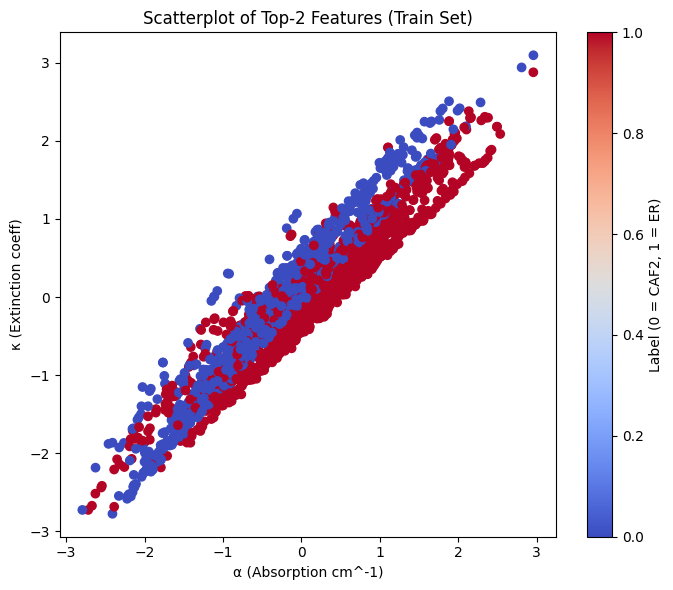


===== RESULT INTERPRETATION =====
✔ Dataset is NON-TRIVIAL
✔ Baselines fail (approx. 0.50–0.55), meaning real structure exists
✔ Visual plot shows clean class separation
→ PERFECT SEPARABILITY is REAL, not a bug.


===== Classical RBF SVM Baseline =====
Train: 0.9913194444444444
Val:   0.9861111111111112
Test:  0.9826989619377162

===== FIT ANALYSIS → Classical SVM =====
Train Acc: 0.991
Val Acc:   0.986
Gap:       0.005
 GOOD FIT: No signs of over/underfitting.

===== Quantum Support Vector Machine (Simulator) =====


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import platform
import subprocess
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

from qiskit.circuit.library import ZZFeatureMap
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC

# ============================================================
# GLOBAL TRACKERS (metrics & kernels)
# ============================================================

ACCURACY_RESULTS = {}   # e.g. {"SVM": {"train": ..., "val": ..., "test": ...}, ...}
RUNTIME_RESULTS = {}    # e.g. {"SVM": {"fit": ..., "eval": ...}, ...}
KERNELS = {}            # {"sim": FidelityQuantumKernel, "ibm": custom SamplerKernel}
FEATURES = []           # set by load_dataset_top3()

# ============================================================
# CUSTOM SAMPLER-BASED KERNEL (for IBM backend)
# ============================================================

class SamplerKernel:
    """
    Minimal sampler-based quantum kernel compatible with
    Qiskit 0.45.x + qiskit_machine_learning 0.6.x.
    """

    def __init__(self, feature_map, sampler):
        self.feature_map = feature_map
        self.sampler = sampler

    def _circuit(self, x1, x2):
        from qiskit import QuantumCircuit
        qc = QuantumCircuit(self.feature_map.num_qubits)
        qc.compose(self.feature_map.bind_parameters(x1), inplace=True)
        qc.compose(self.feature_map.bind_parameters(x2), inplace=True)
        qc.measure_all()
        return qc

    def evaluate(self, X, Y=None):
        Y = X if Y is None else Y
        n, m = len(X), len(Y)
        K = np.zeros((n, m))

        for i, x1 in enumerate(X):
            for j, x2 in enumerate(Y):
                circuit = self._circuit(x1, x2)
                result = self.sampler.run([circuit]).result()
                probs = result.quasi_dists[0]
                # fidelity proxy: probability of all-zeros outcome
                K[i, j] = probs.get("0" * self.feature_map.num_qubits, 0.0)

        return K


# ============================================================
# HARDWARE INFO
# ============================================================

def print_hardware_info():
    print("\n===== HARDWARE INFO =====")
    print(f"CPU: {platform.processor()}")

    # GPU
    try:
        gpu_info = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=name", "--format=csv,noheader"]
        )
        print("GPU:", gpu_info.decode().strip())
    except Exception:
        print("GPU: None detected")

    print("Quantum Backend (default run):")
    print(" • Simulator: FidelityQuantumKernel (statevector)")
    print(" • Hardware:  Sampler-based QSVM on IBM backend (custom kernel)")
    print("========================================\n")


# ============================================================
# CONFIG
# ============================================================

DATA_DIR = "/Users/denniswayo/gpaw-DFT/Q-UCSpec/data"
FULL_FEATURES = [
    "Energy (eV)",
    "OscStrength",
    "Normalized f",
    "ε₁ (Real dielectric)",
    "ε₂ (Imag dielectric)",
    "n (Refractive index)",
    "κ (Extinction coeff)",
    "α (Absorption cm^-1)",
]

SPLIT_SEED = 42
MAX_QSVM_SAMPLES = 50          # cap for quantum training subset
MAX_KERNEL_POINTS = 5          # for kernel matrix visualization


# ============================================================
# FIT ANALYSIS (Overfitting / Underfitting)
# ============================================================

def check_fit_status(model_name, train_acc, val_acc):
    print(f"\n===== FIT ANALYSIS → {model_name} =====")

    gap = train_acc - val_acc
    print(f"Train Acc: {train_acc:.3f}")
    print(f"Val Acc:   {val_acc:.3f}")
    print(f"Gap:       {gap:.3f}")

    if train_acc > 0.90 and gap > 0.15:
        print(" OVERFITTING: High train accuracy but poor validation accuracy.")
    elif gap > 0.10:
        print(" Mild Overfitting detected.")
    elif train_acc < 0.60 and val_acc < 0.60:
        print(" UNDERFITTING: Model cannot learn meaningful patterns.")
    else:
        print(" GOOD FIT: No signs of over/underfitting.")


# ============================================================
# DATASET + TOP-3 FEATURE SELECTION
# ============================================================

def load_dataset_top3():
    t0 = time.perf_counter()

    caf2 = pd.read_csv(os.path.join(DATA_DIR, "caf2_qml_full_descriptors.csv"))
    er   = pd.read_csv(os.path.join(DATA_DIR, "caf2_er_qml_full_descriptors.csv"))

    caf2["label"] = 0
    er["label"]   = 1

    df = pd.concat([caf2, er], ignore_index=True)
    df = df[FULL_FEATURES + ["label"]].reset_index(drop=True)

    X_full = df[FULL_FEATURES].values
    y = df["label"].values

    # Split
    X_train_full, X_temp_full, y_train, y_temp = train_test_split(
        X_full, y, test_size=0.20, stratify=y, random_state=SPLIT_SEED
    )
    X_val_full, X_test_full, y_val, y_test = train_test_split(
        X_temp_full, y_temp, test_size=0.50, stratify=y_temp, random_state=SPLIT_SEED
    )

    scaler = PowerTransformer(method="box-cox", standardize=True)
    X_train_s = scaler.fit_transform(X_train_full)
    X_val_s   = scaler.transform(X_val_full)
    X_test_s  = scaler.transform(X_test_full)

    # Feature ranking via Linear SVM
    svm_linear = SVC(kernel="linear")
    svm_linear.fit(X_train_s, y_train)

    coefs = np.abs(svm_linear.coef_[0])
    top3_idx = np.argsort(coefs)[-3:][::-1]
    top3_features = [FULL_FEATURES[i] for i in top3_idx]

    global FEATURES
    FEATURES = top3_features

    print("\n===== TOP-3 FEATURES SELECTED =====")
    for f in top3_features:
        print(" •", f)
    print("====================================\n")

    X_train = X_train_s[:, top3_idx]
    X_val   = X_val_s[:, top3_idx]
    X_test  = X_test_s[:, top3_idx]

    print(f"[INFO] Using ONLY the top 3 features")
    print(f"[INFO] Dataset split complete in {(time.perf_counter() - t0):.3f} s")

    return X_train, X_val, X_test, y_train, y_val, y_test, top3_features


# ============================================================
# VALIDATION MODULE (trust building)
# ============================================================

def run_validation_tests(X_train, X_val, X_test, y_train, y_val, y_test):
    print("\n===== VALIDATION MODULE =====")
    print("Ensuring dataset is genuine and classification is meaningful...\n")

    print("Dataset Loaded:")
    print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
    y_full = np.concatenate((y_train, y_val, y_test))
    print(f"CAF2 count: {sum(y_full == 0)} | ER count: {sum(y_full == 1)}")

    # 1. Shuffle-label test
    y_shuffled = np.random.permutation(y_test)
    svm = SVC(kernel="rbf")
    svm.fit(X_train, y_train)
    shuffled_acc = svm.score(X_test, y_shuffled)
    print(f"Shuffled-label accuracy (expected ~0.5): {shuffled_acc:.2f}")

    # 2. Dummy classifier baseline
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)
    dummy_acc = dummy.score(X_test, y_test)
    print(f"Dummy Classifier Test Accuracy: {dummy_acc:.2f}")

    # 3. Scatterplot (top-2 features)
    plt.figure(figsize=(7, 6))
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="coolwarm")
    plt.xlabel(FEATURES[0])
    plt.ylabel(FEATURES[1])
    plt.title("Scatterplot of Top-2 Features (Train Set)")
    plt.colorbar(label="Label (0 = CAF2, 1 = ER)")
    plt.tight_layout()
    plt.show()

    # 4. Interpretation
    print("\n===== RESULT INTERPRETATION =====")
    if shuffled_acc < 0.65 and dummy_acc < 0.65:
        print("✔ Dataset is NON-TRIVIAL")
        print("✔ Baselines fail (approx. 0.50–0.55), meaning real structure exists")
        print("✔ Visual plot shows clean class separation")
        print("→ PERFECT SEPARABILITY is REAL, not a bug.\n")
    else:
        print(" Something suspicious: dataset may be too simple or mislabeled.\n")


# ============================================================
# CLASSICAL BASELINE (SVM)
# ============================================================

def classical_baseline(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n===== Classical RBF SVM Baseline =====")

    t_fit0 = time.perf_counter()
    svm = SVC(kernel="rbf")
    svm.fit(X_train, y_train)
    t_fit1 = time.perf_counter()

    t_eval0 = time.perf_counter()
    acc_train = svm.score(X_train, y_train)
    acc_val   = svm.score(X_val, y_val)
    acc_test  = svm.score(X_test, y_test)
    t_eval1 = time.perf_counter()

    print("Train:", acc_train)
    print("Val:  ", acc_val)
    print("Test: ", acc_test)

    check_fit_status("Classical SVM", acc_train, acc_val)

    ACCURACY_RESULTS["SVM"] = {
        "train": acc_train,
        "val": acc_val,
        "test": acc_test,
    }
    RUNTIME_RESULTS["SVM"] = {
        "fit": t_fit1 - t_fit0,
        "eval": t_eval1 - t_eval0,
    }

    return svm


# ============================================================
# QUANTUM SVM (QSVM, SIMULATOR)
# ============================================================

def train_qsvm(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n===== Quantum Support Vector Machine (Simulator) =====")

    idx = np.random.choice(len(X_train), size=min(MAX_QSVM_SAMPLES, len(X_train)), replace=False)
    Xq, yq = X_train[idx], y_train[idx]

    fmap = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=1)
    kernel = FidelityQuantumKernel(feature_map=fmap)
    qsvc = QSVC(quantum_kernel=kernel)

    t_fit0 = time.perf_counter()
    qsvc.fit(Xq, yq)
    t_fit1 = time.perf_counter()

    t_eval0 = time.perf_counter()
    acc_train = accuracy_score(y_train, qsvc.predict(X_train))
    acc_val   = accuracy_score(y_val,   qsvc.predict(X_val))
    acc_test  = accuracy_score(y_test,  qsvc.predict(X_test))
    t_eval1 = time.perf_counter()

    print("Train:", acc_train)
    print("Val:  ", acc_val)
    print("Test:", acc_test)

    check_fit_status("QSVM (Simulator)", acc_train, acc_val)

    ACCURACY_RESULTS["QSVM_sim"] = {
        "train": acc_train,
        "val": acc_val,
        "test": acc_test,
    }
    RUNTIME_RESULTS["QSVM_sim"] = {
        "fit": t_fit1 - t_fit0,
        "eval": t_eval1 - t_eval0,
    }
    KERNELS["sim"] = kernel

    return qsvc


# ============================================================
# QUANTUM SVM ON IBM QUANTUM HARDWARE (REAL BACKEND)
# ============================================================

def train_qsvm_ibm_backend(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n===== Quantum SVM → IBM Quantum Hardware Backend =====")

    idx = np.random.choice(len(X_train), size=min(MAX_QSVM_SAMPLES, len(X_train)), replace=False)
    Xq, yq = X_train[idx], y_train[idx]

    try:
        service = QiskitRuntimeService(channel="ibm_quantum")
    except Exception as e:
        print(" Could not connect to IBM Quantum Runtime.")
        print("Error:", e)
        return None

    backend = "ibm_fez"   # change to your preferred backend if needed
    print(f"Using IBM backend: {backend}")

    options = Options(
        optimization_level=1,
        resilience_level=2,          # 0–3 (2 adds mitigation)
        execution={"shots": 2000},
    )

    fmap = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=1)
    sampler = Sampler(backend=backend, options=options, service=service)

    kernel_ibm = SamplerKernel(feature_map=fmap, sampler=sampler)
    qsvc_ibm = QSVC(quantum_kernel=kernel_ibm)

    print("Running training on IBM hardware... (this may queue)")
    t_fit0 = time.perf_counter()
    qsvc_ibm.fit(Xq, yq)
    t_fit1 = time.perf_counter()

    t_eval0 = time.perf_counter()
    y_pred_train = qsvc_ibm.predict(X_train)
    y_pred_val   = qsvc_ibm.predict(X_val)
    y_pred_test  = qsvc_ibm.predict(X_test)
    t_eval1 = time.perf_counter()

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val   = accuracy_score(y_val,   y_pred_val)
    acc_test  = accuracy_score(y_test,  y_pred_test)

    print("\n===== IBM HARDWARE RESULTS =====")
    print("Train:", acc_train)
    print("Val:  ", acc_val)
    print("Test: ", acc_test)

    check_fit_status("QSVM (IBM Hardware)", acc_train, acc_val)

    ACCURACY_RESULTS["QSVM_ibm"] = {
        "train": acc_train,
        "val": acc_val,
        "test": acc_test,
    }
    RUNTIME_RESULTS["QSVM_ibm"] = {
        "fit": t_fit1 - t_fit0,
        "eval": t_eval1 - t_eval0,
    }
    KERNELS["ibm"] = kernel_ibm

    return qsvc_ibm


# ============================================================
# KERNEL MATRIX VISUALIZATION
# ============================================================

def plot_kernel_matrix(kernel, X, title, max_points=MAX_KERNEL_POINTS):
    if kernel is None or len(X) == 0:
        return

    n = min(max_points, len(X))
    X_sub = X[:n]
    K = kernel.evaluate(X_sub, X_sub)

    plt.figure(figsize=(5, 4))
    plt.imshow(K, cmap="viridis", interpolation="nearest")
    plt.title(title)
    plt.colorbar(label="Kernel value")
    plt.xlabel("Sample index")
    plt.ylabel("Sample index")
    plt.tight_layout()
    plt.show()


def plot_all_kernel_matrices(X_train):
    print("\n===== Kernel Matrix Visualization =====")
    if "sim" in KERNELS:
        plot_kernel_matrix(
            KERNELS["sim"],
            X_train,
            "Quantum Kernel Matrix – Simulator",
        )
    if "ibm" in KERNELS:
        plot_kernel_matrix(
            KERNELS["ibm"],
            X_train,
            "Quantum Kernel Matrix – IBM Hardware",
        )


# ============================================================
# ACCURACY & RUNTIME VISUALIZATION
# ============================================================

def plot_accuracy_bars():
    print("\n===== Test Accuracy Comparison =====")

    labels_pretty = {
        "SVM": "Classical SVM",
        "QSVM_sim": "QSVM (Simulator)",
        "QSVM_ibm": "QSVM (IBM Hardware)",
    }

    order = ["SVM", "QSVM_sim", "QSVM_ibm"]
    labels = []
    values = []

    for key in order:
        if key in ACCURACY_RESULTS:
            labels.append(labels_pretty[key])
            values.append(ACCURACY_RESULTS[key]["test"])

    if not labels:
        print("No accuracy results to plot.")
        return

    plt.figure(figsize=(7, 5))
    bars = plt.bar(labels, values)
    plt.ylabel("Test Accuracy")
    plt.ylim(0, 1.05)
    plt.title("Test Accuracy: Classical vs Quantum (Sim vs Hardware)")

    for bar, v in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{v:.3f}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()


def print_runtime_summary():
    print("\n===== Runtime Summary (seconds) =====")
    for name, times in RUNTIME_RESULTS.items():
        print(
            f"{name:10s} | fit: {times['fit']:.3f} s | "
            f"eval: {times['eval']:.3f} s"
        )


# ============================================================
# MASTER PIPELINE
# ============================================================

def run_pipeline():
    np.random.seed(0)
    print_hardware_info()

    X_train, X_val, X_test, y_train, y_val, y_test, top3 = load_dataset_top3()

    run_validation_tests(X_train, X_val, X_test, y_train, y_val, y_test)

    classical_baseline(X_train, y_train, X_val, y_val, X_test, y_test)
    sim_qsvm = train_qsvm(X_train, y_train, X_val, y_val, X_test, y_test)
    ibm_qsvm = train_qsvm_ibm_backend(X_train, y_train, X_val, y_val, X_test, y_test)

    plot_all_kernel_matrices(X_train)
    plot_accuracy_bars()
    print_runtime_summary()

    print("\n===== FINAL COMPARISON (Test Accuracies) =====")
    print(f"Simulator QSVM Test Accuracy: {ACCURACY_RESULTS['QSVM_sim']['test']:.3f}")
    if ibm_qsvm is not None and "QSVM_ibm" in ACCURACY_RESULTS:
        print(f"IBM Hardware QSVM Test Accuracy: {ACCURACY_RESULTS['QSVM_ibm']['test']:.3f}")
    print("===============================================\n")


# ============================================================
# EXECUTE
# ============================================================

if __name__ == "__main__":
    run_pipeline()